Hallo, kagglers!
My very first participation in Kaggle competitions. 

#### Let's start with import libs and datasets.

In [97]:
#common
import numpy as np
import pandas as pd 
import IPython
from IPython.display import display
import warnings
warnings.simplefilter('ignore')

#visualisation
import seaborn as sns
import matplotlib.pyplot as plt

#metrics and preprocessing
from sklearn.metrics import SCORERS
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, KFold, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle, resample
from sklearn.decomposition import PCA, IncrementalPCA

#classifiers
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB



#### Import data

In [98]:
subm = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

In [99]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Set a random state

In [100]:
RND_ST = 42

#### Create a full dataset

In [101]:
train_ind = train_df['PassengerId'].index
test_ind = test_df['PassengerId']

In [102]:
test_ind = test_ind.tolist()
test_ind.append(891)
test_ind = np.sort(test_ind)
test_ind[:5]

array([891, 892, 893, 894, 895])

In [103]:
full_df = pd.concat([train_df] + [test_df])

In [104]:
full_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We combined train and test datasets to make preprocessing much easier.  

Let's explore the main information about data.

In [105]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We have some missing age values, and a lot of cabin' information. Also 2 missing port of embarkation are in training dataset.

In [106]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Test set has also a lot of missin cabin values and 86 missing age values.

In [107]:
total = full_df.isnull().sum().sort_values(ascending = False)
percent = round(full_df.isnull().sum().sort_values(ascending = False)/len(full_df)*100,2)
pd.concat([total, percent], axis=1, keys=['Total_missing','Percent_missing']).style.background_gradient(cmap='Reds')

,Total_missing,Percent_missing
Cabin,1014,77.460000
Survived,418,31.930000
Age,263,20.090000
Embarked,2,0.150000
Fare,1,0.080000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000


In [108]:
full_df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

I think it's not a crucial mistake to remove the 'Cabin' column because 77% of data is missing and we can't restore or create any important features using this column.  

I'll also try to predict missing age values and fill missing Embarked cells bellow.  

Seems like Parch and SibSp columns are unnecessary. But later we try to make some new features from it.


### Visualization  

#### Distribution of important features  

The most common question - was there any difference in chance to survive betveen males and women.

In [109]:
print('Number of females in a train set is {}'.format(len(train_df.loc[train_df['Sex'] == 'female'])))
print('Number of males in a train set is {}'.format(len(train_df.loc[train_df['Sex'] == 'male'])))

Number of females in a train set is 314
Number of males in a train set is 577


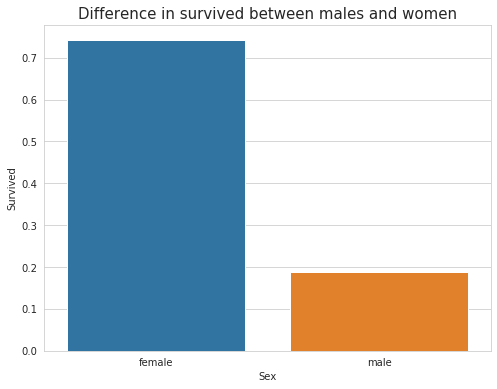

In [110]:
temp_sex = train_df[['Survived', 'Sex']].groupby(['Sex'], as_index=False).mean()

sns.set_style('whitegrid')
plt.figure(figsize=(8,6))
sns.barplot(x='Sex', y='Survived', data=temp_sex)
plt.title('Difference in survived between males and women', size=15);

There were twice more males on Titanic board in a train set, but only 19% of them survived.  

What about passenger' age

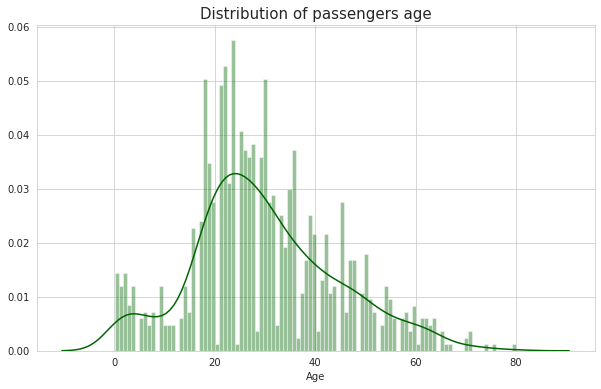

In [111]:
plt.figure(figsize=(10,6))

sns.distplot(full_df['Age'], color='darkgreen', bins=100)

plt.title('Distribution of passengers age', size=15);

The most numbers of passengers were in age between 20 and 45. There were some babies and childern on board, and also some elder passengers.

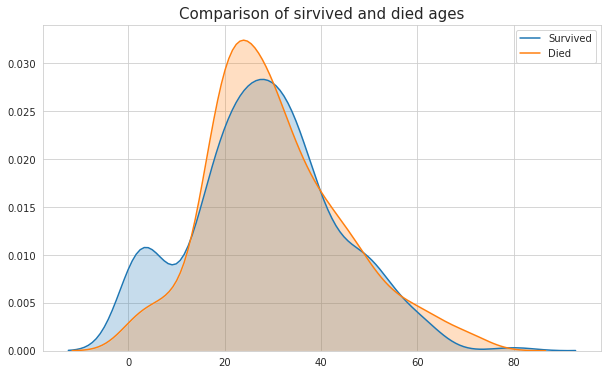

In [112]:
plt.figure(figsize=(10,6))


sns.kdeplot(full_df.loc[full_df['Survived']==1,'Age'], label='Survived', shade=True)
sns.kdeplot(full_df.loc[full_df['Survived']==0,'Age'], label='Died', shade=True)

plt.title('Comparison of sirvived and died ages', size=15);

Most of children were resqued, and most of 20-years-old died.

Let's see how fare, sex and age were affected to Survive.

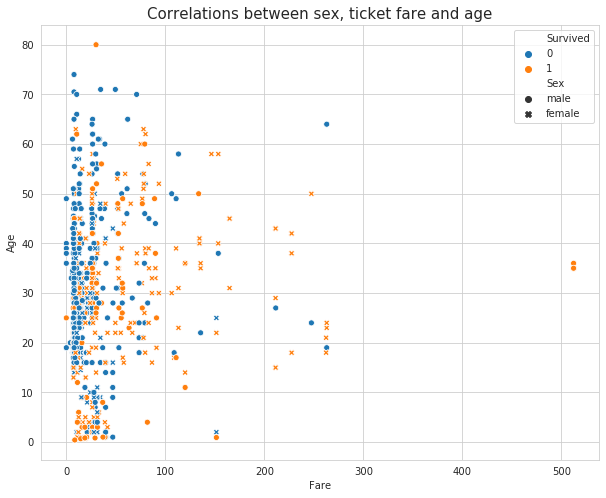

In [113]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=train_df['Fare'], y=train_df['Age'], hue=train_df['Survived'], style=train_df['Sex'])
plt.title('Correlations between sex, ticket fare and age', size=15);

As we can see, women and children were at priority during evacuation and had much more chances to survive. Unfortunately, males were in huge trouble.  
Also, the more you paid for a ticket, the more chances to survive you had.  

What about Pclass?

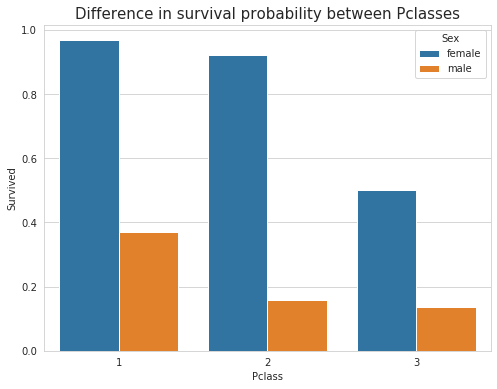

In [114]:
temp_pclass = train_df[['Pclass', 'Survived', 'Sex']].groupby(['Pclass', 'Sex'], as_index=False).mean()

plt.figure(figsize=(8,6))
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=temp_pclass)
plt.title('Difference in survival probability between Pclasses', size=15);

So, the same situation: women had much more chances to survive. We also can see a dramatically drop of surviving probability between Second and Third class women passengers.

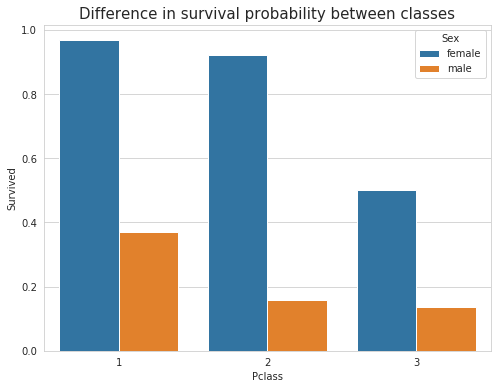

In [115]:
temp_pclass = train_df[['Pclass', 'Survived', 'Sex']].groupby(['Pclass', 'Sex'], as_index=False).mean()

sns.set_style('whitegrid')
plt.figure(figsize=(8,6))
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=temp_pclass)
plt.title('Difference in survival probability between classes', size=15);

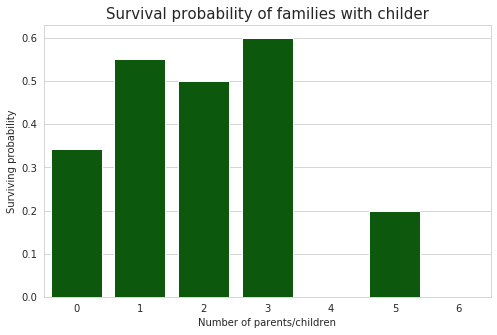

In [116]:
temp_pclass = train_df[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean()

plt.figure(figsize=(8,5))
sns.barplot(x='Parch', y='Survived', data=temp_pclass, color='darkgreen')

plt.xlabel('Number of parents/children')
plt.ylabel('Surviving probability')
plt.title('Survival probability of families with childer', size=15);

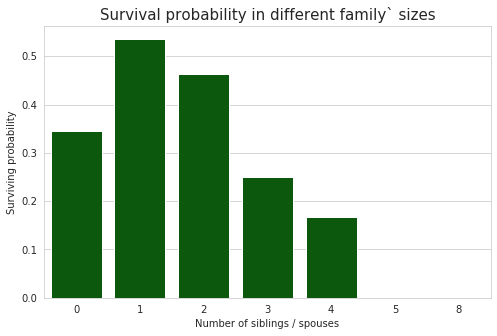

In [117]:
temp_sibsp = train_df[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean()

plt.figure(figsize=(8,5))
sns.barplot(x='SibSp', y='Survived', data=temp_sibsp, color='darkgreen')

plt.xlabel('Number of siblings / spouses')
plt.ylabel('Surviving probability')
plt.title('Survival probability in different family` sizes', size=15);

If a passenger had from one to three family members on board, there was a high probability for one of them to survive. Also, if a passenger travelled alone, he or she had a chance to survive is approx  35.
As I mentioned above, we will use these columns and correlation to create some new features below.  

### Preprocessing and Feature enginereeng

#### Turn Sex into numeric values

In [118]:
full_df.loc[full_df['Sex'] == 'male', 'Sex'] = 1
full_df.loc[full_df['Sex'] == 'female', 'Sex'] = 0

full_df['Sex'] = full_df['Sex'].astype('int')

#### Turn Name into Titles 

In [119]:
import re

In [120]:
def title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""


full_df['Title'] = full_df['Name'].apply(title)

In [121]:
full_df['Title'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Ms            2
Mlle          2
Major         2
Sir           1
Capt          1
Countess      1
Jonkheer      1
Mme           1
Dona          1
Lady          1
Don           1
Name: Title, dtype: int64

Combine rares values into one group 'untitled'

In [122]:
full_df['Title'] = full_df['Title'].replace(['Don', 'Rev', 'Dr','Major', 'Col', 'Capt', 'Countess','Jonkheer', 'Dona'], 'untitled')

In [123]:
full_df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'untitled', 'Mme', 'Ms', 'Lady',
       'Sir', 'Mlle'], dtype=object)

In [124]:
full_df.loc[full_df['Title']=='Master', 'Title'] = 'Mr'
full_df.loc[full_df['Title']=='Mlle', 'Title'] = 'Miss'
full_df.loc[full_df['Title']=='Mme', 'Title'] = 'Miss'
full_df.loc[full_df['Title']=='Ms', 'Title'] = 'Miss'
full_df.loc[full_df['Title']=='Sir', 'Title'] = 'Mr'
full_df.loc[full_df['Title']=='Lady', 'Title'] = 'Miss'

In [125]:
full_df['Title'].value_counts()

Mr          819
Miss        266
Mrs         197
untitled     27
Name: Title, dtype: int64

In [126]:
temp_title = full_df[['Title', 'Survived']].groupby('Title', as_index=False).mean()
temp_title

,Title,Survived
0,Miss,0.705882
1,Mr,0.188172
2,Mrs,0.792000
3,untitled,0.285714


Finally, convert the titles into categorial feature and drop all unnecessary columns(Name, Ticket and Cabin)

In [127]:
title_dict = dict(Mrs = 0, Miss = 1, untitled = 2, Mr = 3)

full_df['Title'] = full_df['Title'].replace(title_dict)

full_df = full_df.drop(['Name', 'Ticket', 'Cabin'], axis=1)

In [128]:
full_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0.0,3,1,22.0,1,0,7.2500,S,3
1,2,1.0,1,0,38.0,1,0,71.2833,C,0
2,3,1.0,3,0,26.0,0,0,7.9250,S,1
3,4,1.0,1,0,35.0,1,0,53.1000,S,0
4,5,0.0,3,1,35.0,0,0,8.0500,S,3


#### Fill missing Fare  

We have only one empty 'Fare' cell in full data.  
Fill it with median fare in 3rd class

In [129]:
full_df.query('Fare == "NaN"')

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
152,1044,NaN,3,1,60.5,0,0,NaN,S,3


In [130]:
full_df['Fare'] = full_df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(value=x.median()))

#### Round fare values and divide it into some bins.

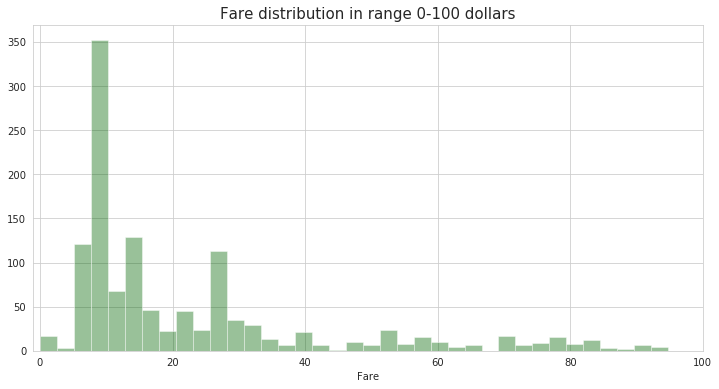

In [131]:
plt.figure(figsize=(12,6))

sns.distplot(full_df['Fare'], kde=False, bins=200, color='darkgreen')
plt.xlim(-1,100)
plt.title('Fare distribution in range 0-100 dollars', size=15);

Most fare values lie in between 10-15 and 15-40 dollars per cabin. We will split the fare values into 5 bins: cheap, moderate, expensive, business, luxury.

In [132]:
def fare_into_bins(row):
    
    fare = row['Fare']
    
    if 0 <= fare < 15:
        return 'cheap'
    elif 15 <= fare < 42:
        return 'moderate'
    elif 42 <= fare < 65:
        return 'expensive'
    elif 65 <= fare < 100:
        return 'business'
    else:
        return 'luxury'
    
full_df['Fare_bins'] = full_df.apply(fare_into_bins, axis=1)

In [133]:
full_df[['Fare_bins', 'Survived']].groupby('Fare_bins',as_index=False).mean().sort_values(by='Survived', ascending=False)

,Fare_bins,Survived
3,luxury,0.735849
0,business,0.646154
2,expensive,0.555556
4,moderate,0.446565
1,cheap,0.249453


The more you pay, the more chances to survive you have.

#### Fill missing Embarked values

In [134]:
full_df.loc[full_df['Embarked'].isna()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Fare_bins
61,62,1.0,1,0,38.0,0,0,80.0,NaN,1,business
829,830,1.0,1,0,62.0,0,0,80.0,NaN,0,business


In [135]:
full_df[['Fare_bins','Embarked','Survived']].groupby(['Embarked','Fare_bins'], as_index=False).mean().query('Fare_bins == "business"')

,Embarked,Fare_bins,Survived
0,C,business,0.869565
5,Q,business,0.500000
8,S,business,0.500000


Let's assume that these passengers came on board in Cherbourg

In [136]:
full_df['Embarked'] = full_df['Embarked'].fillna('C')

#### Encode Embarked and Fare_bin columns

In [137]:
full_df = pd.get_dummies(full_df, drop_first=True)

full_df = full_df.drop('Fare', axis=1)

In [138]:
full_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Title,Embarked_Q,Embarked_S,Fare_bins_cheap,Fare_bins_expensive,Fare_bins_luxury,Fare_bins_moderate
0,1,0.0,3,1,22.0,1,0,3,0,1,1,0,0,0
1,2,1.0,1,0,38.0,1,0,0,0,0,0,0,0,0
2,3,1.0,3,0,26.0,0,0,1,0,1,1,0,0,0
3,4,1.0,1,0,35.0,1,0,0,0,1,0,1,0,0
4,5,0.0,3,1,35.0,0,0,3,0,1,1,0,0,0


#### Fill missing Age

Round babies' age to 1

In [139]:
full_df.loc[full_df['Age'] < 1, 'Age'] = 1

Fill mising age values according to ticket class.

In [140]:
full_df['Age'] = full_df.groupby(['Sex','Pclass'])['Age'].transform(lambda x: x.fillna(value=x.median()))
full_df['Age'] = full_df['Age'].astype('int')

In [141]:
full_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Title,Embarked_Q,Embarked_S,Fare_bins_cheap,Fare_bins_expensive,Fare_bins_luxury,Fare_bins_moderate
0,1,0.0,3,1,22,1,0,3,0,1,1,0,0,0
1,2,1.0,1,0,38,1,0,0,0,0,0,0,0,0
2,3,1.0,3,0,26,0,0,1,0,1,1,0,0,0
3,4,1.0,1,0,35,1,0,0,0,1,0,1,0,0
4,5,0.0,3,1,35,0,0,3,0,1,1,0,0,0


#### Family size  

Lets count a number of relatives on board
	


In [142]:
full_df['Fam_size'] = full_df['SibSp'] + full_df['Parch'] + 1

In [143]:
full_df[['Fam_size', 'Survived']].groupby('Fam_size', as_index=False).mean()

,Fam_size,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


Combine families with low chances to survive together.

In [144]:
full_df['Fam_size'] = full_df['Fam_size'].replace([5,6,7,8,11],1)

In [145]:
full_df[['Fam_size', 'Survived']].groupby('Fam_size', as_index=False).mean()

,Fam_size,Survived
0,1,0.288815
1,2,0.552795
2,3,0.578431
3,4,0.724138


#### Lonely travellers

In [146]:
def alone(row):
    
    size=row['Fam_size']
    
    if size == 1:
        return 1
    else:
        return 0
    
full_df['Lon_trav'] = full_df.apply(alone, axis=1)

In [147]:
full_df[['Lon_trav','Survived']].groupby('Lon_trav', as_index=False).mean()

,Lon_trav,Survived
0,0,0.578767
1,1,0.288815


If you travelled alone, take my deep regrets.

#### Polynomial features

In [148]:
full_df[['Pclass', 'Title', 'Survived']].groupby(['Pclass', 'Title'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Title,Survived
0,1,0,0.976190
1,1,1,0.960000
5,2,1,0.942857
4,2,0,0.902439
8,3,0,0.500000
9,3,1,0.500000
2,1,2,0.461538
3,1,3,0.369369
7,2,3,0.170000
10,3,3,0.135447


Let's create some polynoms from Pclass and Title columns

In [149]:
pf = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

In [150]:
res = pf.fit_transform(full_df[['Pclass', 'Title']]).astype('int')
poly_features = pd.DataFrame(res, columns=['Pclass^2', 'Title^2', 'Pc_T'])



In [151]:
full_df = full_df.reset_index(drop=True)
full_df = full_df.join(poly_features)

In [152]:
full_df['Pclass^2'] = full_df['Pclass^2']**2
full_df['Title^2'] = full_df['Title^2']**2

In [153]:
full_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Title,Embarked_Q,Embarked_S,Fare_bins_cheap,Fare_bins_expensive,Fare_bins_luxury,Fare_bins_moderate,Fam_size,Lon_trav,Pclass^2,Title^2,Pc_T
0,1,0.0,3,1,22,1,0,3,0,1,1,0,0,0,2,0,9,9,9
1,2,1.0,1,0,38,1,0,0,0,0,0,0,0,0,2,0,1,0,0
2,3,1.0,3,0,26,0,0,1,0,1,1,0,0,0,1,1,9,1,3
3,4,1.0,1,0,35,1,0,0,0,1,0,1,0,0,2,0,1,0,0
4,5,0.0,3,1,35,0,0,3,0,1,1,0,0,0,1,1,9,9,9


#### Finally, drop meaningless columns and check the full set

In [154]:
full_df = full_df.drop(['SibSp','Parch'], axis=1)

In [155]:
full_df.isna().sum()

PassengerId              0
Survived               418
Pclass                   0
Sex                      0
Age                      0
Title                    0
Embarked_Q               0
Embarked_S               0
Fare_bins_cheap          0
Fare_bins_expensive      0
Fare_bins_luxury         0
Fare_bins_moderate       0
Fam_size                 0
Lon_trav                 0
Pclass^2                 0
Title^2                  0
Pc_T                     0
dtype: int64

#### Divide full set to train and test sets again


In [156]:
y_train = full_df.loc[:len(train_ind)-1, 'Survived'].astype('int')

X_train = full_df.query('index in @train_ind').drop(['PassengerId', 'Survived'], axis=1)
X_test = full_df.query('index in @test_ind').drop(['PassengerId', 'Survived'], axis=1)

Let's drop age from training and test datasets.

In [157]:
X_train_aged = X_train.drop('Age', axis=1)
X_test_aged = X_train.drop('Age', axis=1)

### Model selection

#### Featuers scaling  

We need this step for some kinds of classifiers.

In [158]:
MinMax = MinMaxScaler()

MinMax.fit(X_train)

X_train_scaled = MinMax.transform(X_train)
X_test_scaled = MinMax.transform(X_test)

MinMax.fit(X_train_aged)
X_train_aged_sc = MinMax.transform(X_train_aged)
X_test_aged_sc = MinMax.transform(X_test_aged)

#### Setup some models

In [159]:
#### Logistic Regression

lr = LogisticRegression(n_jobs=-1)


### Random Forest

rfc = RandomForestClassifier(random_state=RND_ST, n_jobs=-1)

params_rfc = dict(
                  n_estimators=range(150,600,25),
                  max_features=range(2,8),
                  max_depth=range(3,7), 
                  min_samples_split=[2,3,4])


### Nearest Neighbors

knn = KNeighborsClassifier(n_jobs=-1)

params_knn = dict(
                  metric = ['manhattan', 'minkowski'],
                  n_neighbors = range(5,15),
                  leaf_size=range(30,50,2))


### Ada Boost

ada = AdaBoostClassifier(random_state=RND_ST)

params_ada = dict(
                  n_estimators=range(100,500,25))


### Support Vector

svc = SVC(random_state=RND_ST)

params_svc = dict(
                  gamma = np.logspace(-6, -1, 5),
                  tol=[1e-3, 1e-4, 1e-5])

### Linear Support Vector

lsv = LinearSVC(random_state=RND_ST)

params_lsv = dict(
                  C = [0.1, 1, 10], 
                  penalty = ['l1', 'l2'],
                  max_iter = [1000,1500,2000])


### Gradient Boosting

gbc = GradientBoostingClassifier(random_state=RND_ST, max_depth=3)

params_gbc = dict(
                  n_estimators=range(10,500,10),
                  learning_rate=[0.01, 0.1, 1, 5, 10],
                  max_leaf_nodes=range(1,6))

### Stochaic Gradient Descent

sgd = SGDClassifier(random_state=RND_ST)

params_sgd = dict(
                  max_iter=[500,1000,1500],
                  tol=[1e-3, 1e-4, 1e-5])

In [160]:
clf = [rfc, lsv, knn, ada, svc, gbc, sgd]
clf_names = ['random_forest', 'linear_vector', 'near_neighbours', 'ada_boost', 'support_vector', 'gradient_boosting', 'stochaic_gradient_descent']
params = [params_rfc, params_lsv, params_knn, params_ada, params_svc, params_gbc, params_sgd]

Create functions for CrossValidation and Randomized searches to find the best hyperparameters.

In [161]:
def rs(model, params, feat, targ):
    
    search = RandomizedSearchCV(model, params, cv=7, scoring='f1', n_jobs=-1)
    search.fit(feat, targ)

    print(search.best_score_)
    print(search.best_params_)

In [162]:
def gs(model, params, feat, targ):
    
    gs = GridSearchCV(model, params, cv=7, scoring='f1', n_jobs=-1)
    
    gs.fit(feat, targ)

    print(gs.best_score_)
    print(gs.best_params_)

In [163]:
for clf_, name, param in zip(clf, clf_names, params):
    
    print(name)
    rs(clf_, param, X_train, y_train)
    print()

random_forest
0.7494554039371274
{'n_estimators': 200, 'min_samples_split': 2, 'max_features': 2, 'max_depth': 6}

linear_vector
0.7214528861270864
{'penalty': 'l2', 'max_iter': 1000, 'C': 0.1}

near_neighbours
0.7728037436221967
{'n_neighbors': 5, 'metric': 'minkowski', 'leaf_size': 30}

ada_boost
0.72204523662512
{'n_estimators': 150}

support_vector
0.777946961077336
{'tol': 0.0001, 'gamma': 0.1}

gradient_boosting
0.7670975367967842
{'n_estimators': 320, 'max_leaf_nodes': 5, 'learning_rate': 0.1}

stochaic_gradient_descent
0.6247172581911051
{'tol': 0.001, 'max_iter': 500}



Time to find the best model with f1 score.

In [164]:
for clf_, name, param in zip(clf, clf_names, params):
    
    print(name)
    rs(clf_, param, X_train_aged, y_train)
    print()

random_forest
0.7125233817256836
{'n_estimators': 275, 'min_samples_split': 2, 'max_features': 4, 'max_depth': 4}

linear_vector
0.7102445154055907
{'penalty': 'l2', 'max_iter': 1500, 'C': 0.1}

near_neighbours
0.7038889970535175
{'n_neighbors': 14, 'metric': 'manhattan', 'leaf_size': 46}

ada_boost
0.6813788999242492
{'n_estimators': 400}

support_vector
0.7012472523473743
{'tol': 0.001, 'gamma': 0.00031622776601683794}

gradient_boosting
0.7011431301302148
{'n_estimators': 280, 'max_leaf_nodes': 5, 'learning_rate': 1}

stochaic_gradient_descent
0.5719046979690084
{'tol': 0.001, 'max_iter': 500}



Okay, seems like age is an important feature.

In [165]:
gs(knn, params_knn, X_train_scaled, y_train)

0.7528349271737235
{'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 5}


Let's try to find the best parameters for Gradient Boosting in two steps. First - define the number of estimators, then search for the best learning rate.

In [166]:
gbc = GradientBoostingClassifier(random_state=RND_ST, max_depth=3)

params_gbc_estim = dict(
                  n_estimators=range(10,500,5))

params_gbc_learn_rate = dict(
                  learning_rate=[0.01, 0.05, 0.1, 0.5, 1, 10])

In [167]:
gs(gbc, params_gbc_estim, X_train, y_train)

0.7720148581232475
{'n_estimators': 80}


In [168]:
gbc_1 = GradientBoostingClassifier(random_state=RND_ST, max_depth=3, n_estimators=130)

In [169]:
gs(gbc_1, params_gbc_learn_rate, X_train, y_train)


0.7641098422469872
{'learning_rate': 0.1}


0.77 - this is the best f1 value between all searches. Try to apply upgrated model to the test features.

Create and fit the final model

In [170]:
model_lsv = LinearSVC(C=0.1, max_iter=2000, penalty='l2', random_state=RND_ST)

In [171]:
model_svc = SVC(tol=0.0001, gamma=0.1, random_state=RND_ST)

In [172]:
model_gdc_1 = GradientBoostingClassifier(
    n_estimators=275, min_samples_split=2, min_samples_leaf=4, max_depth=4, learning_rate=0.1, random_state=RND_ST)

In [173]:
model_gdc_1 = GradientBoostingClassifier(
    n_estimators=130, max_depth=3, learning_rate=0.1, random_state=RND_ST)

What is the most importance features for the final model?

In [174]:
def plot_feature_importances(model, feat, targ):
    
    model.fit(feat, targ)
    n_features = feat.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), feat.columns)
    plt.xlabel("Features importance")
    plt.ylabel("Features")


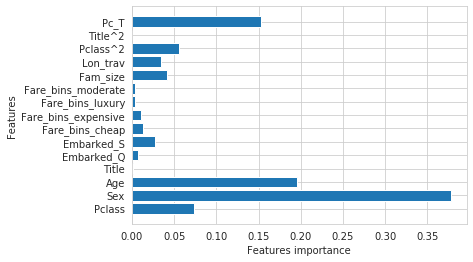

In [175]:
plot_feature_importances(model_gdc_1, X_train, y_train)

### Submission  

#### Final Prediction

In [176]:
def prediction(model, feat_tr, feat_test, targ):
    
    model.fit(feat_tr, targ)

    pred_final = pd.DataFrame(model.predict(feat_test), columns=['Survived'])
 
    return pred_final

In [177]:
pred = prediction(model_svc, X_train, X_test, y_train)

#### Export submission

In [178]:
submission = pd.DataFrame(test_df['PassengerId'])

submission = submission.join(pred)

submission.to_csv('/kaggle/working/titanic_sub.csv', index=False)

---

Best score :
0.77551 - LinearSVC (model_lsv, X_train, X_test)